# 使用geoPandas處理地理資料

# 載入台北市區界圖
* 使用geopandas.read_file讀取shapefile
* 利用pandas選出台北市各區區界

In [1]:
import geopandas
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
pylab.rcParams['figure.figsize'] = (12.0, 8.0)

In [4]:
台灣地理分區 = geopandas.read_file('./鄉鎮市界/Town_MOI_1041215.shp')

In [5]:
台灣地理分區.head()

,Add_Accept,Add_Date,C_Name,County_ID,OBJECTID,Remark,T_Desc,T_Name,T_UID,Town_ID,geometry
0,None,None,臺東縣,10014,909,None,None,成功鎮,178,1001402,"POLYGON ((121.409815737 23.21369278500009, 121..."
1,None,None,屏東縣,10013,910,None,None,佳冬鄉,164,1001321,"POLYGON ((120.5484580210001 22.46067220300006,..."
2,None,None,雲林縣,10009,920,None,None,麥寮鄉,118,1000913,"POLYGON ((120.3019750420001 23.81624614400005,..."
3,None,None,臺東縣,10014,926,None,None,綠島鄉,376,1001411,"(POLYGON ((121.491547243 22.67745703900005, 12..."
4,None,None,臺東縣,10014,927,None,None,蘭嶼鄉,369,1001416,(POLYGON ((121.6117956420001 21.94289657000007...


In [6]:
臺北市區界圖 = 台灣地理分區[台灣地理分區['C_Name'] == '臺北市']

In [7]:
臺北市區界圖['T_Name'] = 臺北市區界圖['T_Name'].apply(lambda t: t[:2])

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
臺北市區界圖geoJson = 臺北市區界圖.to_json()

In [9]:
臺北市區界圖 = 臺北市區界圖.set_index('T_Name')

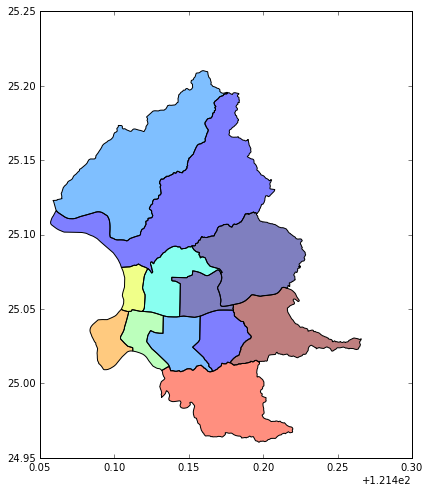

In [10]:
臺北市區界圖.plot()

# 計算各區重心

In [11]:
臺北市區界圖['重心'] = 臺北市區界圖.centroid

In [12]:
臺北市區界圖['x'] = 臺北市區界圖['重心'].apply(lambda t: t.x)
臺北市區界圖['y'] = 臺北市區界圖['重心'].apply(lambda t: t.y)

In [13]:
臺北市區界圖[['x', 'y']]

,x,y
T_Name,,
松山,121.557802,25.059771
信義,121.571648,25.030714
大安,121.543424,25.026865
中山,121.538378,25.069857
中正,121.519857,25.032518
大同,121.513228,25.063856
萬華,121.497332,25.029344
文山,121.573978,24.988655
南港,121.609761,25.036063


In [15]:
import folium

x = 臺北市區界圖['x'].mean()
y = 臺北市區界圖['y'].mean()

地圖 = folium.Map(location=[y, x], zoom_start=11)

for x, y, sub in zip(臺北市區界圖['x'], 臺北市區界圖['y'], 臺北市區界圖.index):
    folium.Marker([y, x], popup=sub).add_to(地圖)

folium.GeoJson(臺北市區界圖geoJson, name='臺北市區界').add_to(地圖)

folium.LayerControl().add_to(地圖)

地圖


# 載入各區各年度人口數

In [19]:
from pyexcel_ods3 import get_data
import pandas as pd
from collections import OrderedDict
import os

In [20]:
!ls ./台北市人口/

61111644391.ods 62161510876.ods 62161593160.ods 62161595674.ods


In [21]:
台北市人口 = OrderedDict()
for file in os.listdir('./台北市人口/'):
    if file.endswith('.ods'):
        data = get_data('./台北市人口/{}'.format(file))
        台北市人口.update(data)

## 排序年份

In [22]:
年份 = list(台北市人口.keys())
年份.sort()
年份 = 年份[5:] + 年份[:4]

In [23]:
columns = ['區名', '戶數', '人數', '男', '女']
各區人數 = []

for year in 年份:
    人口統計 = pd.DataFrame(台北市人口[year][4:], columns=columns)
    人口統計 = 人口統計.set_index('區名')
    各區人數.append(人口統計['人數'])

## 取民國79以後的人口資料

In [24]:
現今台北市各區名稱 = 各區人數[-1].index

In [25]:
台北市各區人口 = pd.DataFrame(各區人數, index=年份).ix['79年':][現今台北市各區名稱] 

In [26]:
台北市各區人口總和 = 台北市各區人口.sum(axis=1)

In [27]:
for 區域 in 現今台北市各區名稱:
    台北市各區人口[區域] = 台北市各區人口[區域] / 台北市各區人口總和

In [28]:
台北市各區人口 = 台北市各區人口.T

In [29]:
台北市各區人口

,79年,80年,81年,82年,83年,84年,85年,86年,87年,88年,...,94年,95年,96年,97年,98年,99年,100年,101年,102年,103年
松山,0.080206,0.079968,0.079241,0.080313,0.080456,0.080165,0.080577,0.079208,0.078865,0.078603,...,0.079538,0.079560,0.080245,0.080100,0.079770,0.079592,0.079197,0.078895,0.078296,0.077886
信義,0.090171,0.090305,0.091884,0.092436,0.093054,0.092591,0.092199,0.092317,0.091858,0.091590,...,0.088206,0.087939,0.087046,0.086838,0.086432,0.085953,0.085456,0.085191,0.085053,0.084985
大安,0.130422,0.129547,0.126764,0.126635,0.127115,0.125155,0.121749,0.120922,0.120837,0.120058,...,0.119312,0.119355,0.119776,0.119656,0.119509,0.118974,0.118389,0.117246,0.116643,0.116083
中山,0.087246,0.086815,0.086304,0.085471,0.085381,0.084161,0.082898,0.081677,0.081505,0.081267,...,0.082903,0.083420,0.083096,0.083434,0.083701,0.084057,0.084536,0.084789,0.085149,0.085296
中正,0.068120,0.067575,0.067221,0.066055,0.065839,0.064892,0.064057,0.063481,0.063082,0.062592,...,0.060135,0.060254,0.060658,0.060748,0.060885,0.060920,0.060902,0.060659,0.060725,0.060462
大同,0.055591,0.055120,0.054711,0.053113,0.052069,0.051312,0.051502,0.051438,0.050972,0.050544,...,0.048468,0.048219,0.047971,0.047524,0.047326,0.047580,0.047771,0.048185,0.048323,0.048467
萬華,0.085648,0.084916,0.084710,0.083255,0.082015,0.081274,0.081021,0.080224,0.079464,0.078727,...,0.074432,0.074035,0.073203,0.072576,0.072269,0.072209,0.071994,0.072058,0.072019,0.072055
文山,0.083284,0.083059,0.083935,0.084358,0.084039,0.086486,0.088276,0.090575,0.092403,0.094121,...,0.098974,0.099313,0.099520,0.099781,0.100048,0.100164,0.100507,0.100743,0.101001,0.101365
南港,0.043069,0.043328,0.043655,0.043410,0.042739,0.042695,0.042886,0.042710,0.042690,0.042808,...,0.043209,0.043027,0.043250,0.043338,0.043395,0.043541,0.043807,0.044325,0.044575,0.044872
內湖,0.076306,0.079011,0.079942,0.081466,0.082888,0.085859,0.089036,0.091340,0.092670,0.094494,...,0.100076,0.100532,0.100985,0.101722,0.102670,0.103195,0.103982,0.104752,0.105282,0.105749


# 以各區人口當權重計算台北市重心

In [30]:
臺北市各區重心 = 臺北市區界圖[['x', 'y']]

In [31]:
臺北市各區重心.index.name = '區名'

In [32]:
各年份重心 = []

for year in 台北市各區人口.columns:
    各年份重心.append(
        (sum(臺北市各區重心['x'] * 台北市各區人口[year]), sum(臺北市各區重心['y'] * 台北市各區人口[year]))
    )
各年份重心 = pd.Series(各年份重心, index=台北市各區人口.columns)

In [33]:
各年份重心

79年     (121.547116677, 25.0595722231)
80年     (121.547314609, 25.0597382068)
81年     (121.547479427, 25.0598331587)
82年     (121.547707694, 25.0600407543)
83年     (121.547821721, 25.0601936147)
84年     (121.548099979, 25.0602788398)
85年     (121.548330283, 25.0604063986)
86年     (121.548537254, 25.0603798363)
87年     (121.548689898, 25.0603023922)
88年      (121.548877625, 25.060260891)
89年     (121.549029434, 25.0602579703)
90年     (121.549111294, 25.0602658082)
91年     (121.549192227, 25.0602710327)
92年     (121.549289977, 25.0603507647)
93年     (121.549390918, 25.0603872053)
94年     (121.549506739, 25.0603692826)
95年     (121.549534633, 25.0603553981)
96年     (121.549592538, 25.0603670603)
97年     (121.549668465, 25.0603978156)
98年     (121.549726942, 25.0604034684)
99年     (121.549739972, 25.0604302636)
100年    (121.549786139, 25.0604414534)
101年    (121.549843056, 25.0604634994)
102年    (121.549873749, 25.0604646099)
103年    (121.549910892, 25.0604660713)
dtype: object

# 以地圖呈現台北市重心變化

In [34]:
import folium

In [35]:
x, y = average([_[0] for _ in 各年份重心]), average([_[1] for _ in 各年份重心])
地圖 = folium.Map(location=[y, x], zoom_start=17)

In [36]:
for pos, sub in zip(各年份重心, 各年份重心.index):
    folium.Marker([pos[1], pos[0]], popup=sub).add_to(地圖)

In [37]:
地圖